<a href="https://colab.research.google.com/github/kota-mizu/smbc_price_forecasting/blob/main/inference_notebook/PCA_SVR_LGBM_Ensemble_vol.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


データ読み込み


In [2]:
DIR = '/content/drive/MyDrive/signate_smbc/'
submission_path = '/content/drive/MyDrive/signate_smbc/submission/'

In [ ]:
# train_raw_df  = pd.read_csv(data_path + 'train.csv')
# test_raw_df   = pd.read_csv(data_path + 'test.csv')
# sample_submission_df = pd.read_csv(data_path + 'sample_submit.csv', header=None)  # header 無し
# feature_description = pd.read_csv(data_path + 'feature_description.csv', index_col = 0)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR,SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from copy import deepcopy
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

In [ ]:
def one_hot_encoder(df):
  """
  one hot encoder.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: The one hot encoded dataframe.
  """
  for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
      one_hot = pd.get_dummies(df[col], prefix=f'{col}_', dtype=int)
      df = df.drop(col, axis=1)
      df = df.join(one_hot)
  return df

def generate_hour_one_hot(df):
  one_hot = pd.get_dummies(df['hour'].astype(str), prefix='hour_', dtype=int)
  df = df.drop('hour', axis=1)
  df = df.join(one_hot)
  return df

def generate_dayofweek_one_hot(df):
  one_hot = pd.get_dummies(df['dayofweek'].astype(str), prefix='dayofweek_', dtype=int)
  df = df.drop('dayofweek', axis=1)
  df = df.join(one_hot)
  return df

def generate_dayofyear_one_hot(df):
  one_hot = pd.get_dummies(df['dayofyear'].clip(upper=365).astype(str), prefix='dayofyear_', dtype=int)
  df = df.drop('dayofyear', axis=1)
  df = df.join(one_hot)
  return df

def setup_time(df):
  """
  setup time(utc=True) values to dataframe index.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: time indexed dataframe.
  """
  df['time'] = pd.to_datetime(df['time'], utc=True)
  df.set_index('time', inplace=True)
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  return df

def setup_dataframe(file):
  """
  setup dataframe.

  Args:
      file: csv file.

  Returns:
      pd.DataFrame: dataframe.
  """
  df = pd.read_csv(os.path.join(DIR, file))
  df = setup_time(df)
  #df = generate_hour_one_hot(df)
  #df = generate_dayofweek_one_hot(df)
  #df = generate_dayofyear_one_hot(df)
  df = one_hot_encoder(df)
  return df.fillna(0)

def one_hot_times(df):
  """
  one hot encoder.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: The one hot encoded dataframe.
  """
  df = generate_hour_one_hot(df)
  df = generate_dayofweek_one_hot(df)
  df = generate_dayofyear_one_hot(df)
  return df

In [ ]:
# prompt: 引数のdataframe(indexにdatetimeが設置済)にhour, dayofweek, dayofyearを追加、ただしdayofyearの上限は365

def add_time_features(df):
  """
  Add hour, dayofweek, and dayofyear features to a dataframe with a DatetimeIndex.

  Args:
      df (pd.DataFrame): The source dataframe with a DatetimeIndex.

  Returns:
      pd.DataFrame: The dataframe with added time features.
  """
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  #df = generate_hour_one_hot(df)
  #df = generate_dayofweek_one_hot(df)
  #df = generate_dayofyear_one_hot(df)

  return df

#HOUR_COLUMNS = [f'hour__{hour}' for hour in range(24)]
#DAYOFWEEK_COLUMNS = [f'dayofweek__{dayofweek}' for dayofweek in range(7)]
#DAYOFYEAR_COLUMNS = [f'dayofyear__{dayofyear}' for dayofyear in range(1,366)]

In [ ]:
train_df = setup_dataframe('train.csv')
test_df = setup_dataframe('test.csv')

In [ ]:
# prompt: train_dfの数値項目を対象に年,月ごとのprice_actualとの相関係数(spearman)のデータフレームを作成

train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'price_actual', 'year', and 'month' from the numeric columns for correlation calculation against 'price_actual'
numeric_cols_for_corr = [col for col in numeric_cols if col not in ['price_actual', 'year', 'month', 'hour', 'dayofyear', ]]

# Create an empty dictionary to store the correlation dataframes
monthly_yearly_correlations = {}

# Iterate through each numeric column (excluding 'price_actual', 'year', 'month')
for col in numeric_cols_for_corr:
    # Calculate the Spearman correlation for each year and month
    corr_df = train_df.groupby(['year', 'month'])[[col, 'price_actual']].corr(method='spearman').unstack().iloc[:, 1].unstack()
    monthly_yearly_correlations[col] = corr_df

# Combine the correlation dataframes into a single dataframe
# This will be a MultiIndex dataframe where the outer index is the column name
# and the inner index is the year and month
correlation_summary_df = pd.concat(monthly_yearly_correlations, axis=0)

# Display the resulting dataframe
correlation_summary_df.fillna(0, inplace=True)
correlation_summary_df_abs = correlation_summary_df.abs()

corr_mean_val = correlation_summary_df_abs.mean()
corr_std_val = correlation_summary_df_abs.std(ddof=0)

# Calculate the threshold: mean + 2 * std
target_threshold_2std = corr_mean_val + 2.0 * corr_std_val

# Identify data points where the absolute correlation is greater than the threshold in any month
# We use .stack() to make it easier to filter based on values
anomalous_correlations = correlation_summary_df_abs[correlation_summary_df_abs > target_threshold_2std].stack().reset_index()

print("Data points where absolute correlation is greater than mean + 2*std in any month:")
FEATURES = anomalous_correlations['level_0'].unique()
FEATURES = [column for column in FEATURES if column not in ['price_actual', 'year', 'month', 'hour', 'dayofyear', 'dayofweek']]
#FEATURES
#

Data points where absolute correlation is greater than mean + 2*std in any month:


In [ ]:
# --- 設定: 全てのカラムを省略せずに表示する ---
pd.set_option('display.max_columns', None)

# --- 確認: DataFrameの先頭5行を表示 ---
# この設定の後で .head() を実行すると、横に長くなりますが、全てのカラムが表示されます。
print("--- train_df.head() の表示（全カラム） ---")
display(train_df.head()) #

--- train_df.head() の表示（全カラム） ---


,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,total_load_actual,valencia_temp,valencia_temp_min,valencia_temp_max,valencia_pressure,valencia_humidity,valencia_wind_speed,valencia_wind_deg,valencia_rain_1h,valencia_rain_3h,valencia_snow_3h,valencia_clouds_all,valencia_weather_id,madrid_temp,madrid_temp_min,madrid_temp_max,madrid_pressure,madrid_humidity,madrid_wind_speed,madrid_wind_deg,madrid_rain_1h,madrid_rain_3h,madrid_snow_3h,madrid_clouds_all,madrid_weather_id,bilbao_temp,bilbao_temp_min,bilbao_temp_max,bilbao_pressure,bilbao_humidity,bilbao_wind_speed,bilbao_wind_deg,bilbao_rain_1h,bilbao_rain_3h,bilbao_snow_3h,bilbao_clouds_all,bilbao_weather_id,barcelona_temp,barcelona_temp_min,barcelona_temp_max,barcelona_pressure,barcelona_humidity,barcelona_wind_speed,barcelona_wind_deg,barcelona_rain_1h,barcelona_rain_3h,barcelona_snow_3h,barcelona_clouds_all,barcelona_weather_id,seville_temp,seville_temp_min,seville_temp_max,seville_pressure,seville_humidity,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,price_actual,hour,dayofweek,dayofyear,valencia_weather_main__clear,valencia_weather_main__clouds,valencia_weather_main__drizzle,valencia_weather_main__fog,valencia_weather_main__mist,valencia_weather_main__rain,valencia_weather_main__smoke,valencia_weather_main__thunderstorm,valencia_weather_description__broken clouds,valencia_weather_description__drizzle,valencia_weather_description__few clouds,valencia_weather_description__fog,valencia_weather_description__heavy intensity drizzle,valencia_weather_description__heavy intensity rain,valencia_weather_description__heavy intensity shower rain,valencia_weather_description__light intensity drizzle,valencia_weather_description__light intensity shower rain,valencia_weather_description__light rain,valencia_weather_description__mist,valencia_weather_description__moderate rain,valencia_weather_description__overcast clouds,valencia_weather_description__proximity thunderstorm,valencia_weather_description__scattered clouds,valencia_weather_description__shower rain,valencia_weather_description__sky is clear,valencia_weather_description__smoke,valencia_weather_description__thunderstorm,valencia_weather_description__thunderstorm with heavy rain,valencia_weather_description__thunderstorm with light rain,valencia_weather_description__thunderstorm with rain,valencia_weather_description__very heavy rain,valencia_weather_icon__01,valencia_weather_icon__01d,valencia_weather_icon__01n,valencia_weather_icon__02,valencia_weather_icon__02d,valencia_weather_icon__02n,valencia_weather_icon__03,valencia_weather_icon__03d,valencia_weather_icon__03n,valencia_weather_icon__04,valencia_weather_icon__04d,valencia_weather_icon__04n,valencia_weather_icon__09d,valencia_weather_icon__09n,valencia_weather_icon__10,valencia_weather_icon__10d,valencia_weather_icon__10n,valencia_weather_icon__11d,valencia_weather_icon__11n,valencia_weather_icon__50d,valencia_weather_icon__50n,madrid_weather_main__clear,madrid_weather_main__clouds,madrid_weather_main__drizzle,madrid_weather_main__fog,madrid_weather_main__haze,madrid_weather_main__mist,madrid_weather_main__rain,madrid_weather_main__snow,madrid_weather_main__thunderstorm,madrid_weather_description__broken clouds,madrid_weather_description__drizzle,madrid_weather_description__few clouds,madrid_weather_description__fog,madrid_weather_description__haze,madrid_weather_description__heavy intensity rain,madrid_weather_description__heavy intensity shower rain,madrid_weather_description__light intensity drizzle,madrid_weather_description__light intensity shower rain,madrid_weather_description

In [ ]:
len(FEATURES)


106

In [ ]:
GENERATION_FEATURES = [column for column in FEATURES if column.startswith('generation')]
WEATHER_FEATURES = [column for column in FEATURES if column not in GENERATION_FEATURES]

GENERATION_FEATURESとWEATHER_FEATURESを合わせた特徴量のPCAを取得する


In [ ]:
# prompt: GENERATION_FEATURESに定義された項目でPCAを取得

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# PCAモデルの初期化 (コンポーネント数を指定しない場合は、特徴量の数になる)
pca_generation = PCA(n_components=3, random_state=42)
pca_weather = PCA(n_components=5, random_state=42)
pca_all = PCA(n_components=8, random_state=42)

# データを変換
principal_components_g = pca_generation.fit_transform(train_df[GENERATION_FEATURES])
principal_components_w = pca_weather.fit_transform(train_df[WEATHER_FEATURES])
principal_components_a = pca_all.fit_transform(train_df[GENERATION_FEATURES + WEATHER_FEATURES])

def calculate_vector_norm_ratio(vec1: np.ndarray, vec2: np.ndarray) -> float:
  """
  Calculate the ratio of the norms of two vectors.

  Args:
      vec1 (np.ndarray): The first input vector.
      vec2 (np.ndarray): The second input vector.

  Returns:
      float: The ratio of the norm of vec1 to the norm of vec2.
             Returns 0 if the norm of vec2 is zero to avoid division by zero.
  """
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm2 == 0:
    return 0.0
  else:
    return norm1 / norm2

def calculate_cossim(vec1: np.ndarray, vec2: np.ndarray) -> float:
  """
  Calculate the cosine similarity between two vectors.

  Args:
      vec1 (np.ndarray): The first input vector.
      vec2 (np.ndarray): The second input vector.

  Returns:
      float: The cosine similarity between the two vectors.
  """
  # Reshape vectors for cosine_similarity function if they are 1D
  vec1 = vec1.flatten()
  vec2 = vec2.flatten()

  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def generation_feature_relations(x,pca=pca_generation):
  """
  Calculate relations between generation features using PCA.

  Args:
      x (np.ndarray): vector of generation features.

  Returns:
      cosine_similarity (float): The cosine similarity between two vectors.
      vector_norm_ratio (float): The ratio of the norms of two vectors.
      principal_components_1 (first): The principal components of the input vector.
      principal_components_2 (second): The principal components of the input vector.
      principal_components_3 (third): The principal components of the input vector.
  """
  x_trans = pca.transform([x])
  x_inv = pca.inverse_transform(x_trans)
  cosine_similarity_value = calculate_cossim(x.values, x_inv)
  vector_norm_ratio_value = calculate_vector_norm_ratio(x, x_inv)
  return cosine_similarity_value, vector_norm_ratio_value,x_trans[0][0],x_trans[0][1],x_trans[0][2]

def weather_feature_relations(x,pca=pca_weather):
  """
  Calculate relations between weather features using PCA.

  Args:
      x (np.ndarray): vector of waether features.

  Returns:
      cosine_similarity (float): The cosine similarity between two vectors.
      vector_norm_ratio (float): The ratio of the norms of two vectors.
      principal_components_1 (first): The principal components of the input vector.
      principal_components_2 (second): The principal components of the input vector.
      principal_components_3 (third): The principal components of the input vector.
      principal_components_4 (4-th): The principal components of the input vector.
      principal_components_5 (5-th): The principal components of the input vector.
  """
  x_trans = pca.transform([x])
  x_inv = pca.inverse_transform(x_trans)
  cosine_similarity_value = calculate_cossim(x.values, x_inv)
  vector_norm_ratio_value = calculate_vector_norm_ratio(x, x_inv)
  return cosine_similarity_value, vector_norm_ratio_value,x_trans[0][0],x_trans[0][1],x_trans[0][2],x_trans[0][3],x_trans[0][4]

def all_feature_relations(x,pca=pca_all):
  """
  Calculate relations between all features using PCA.

  Args:
      x (np.ndarray): vector of all features.

  Returns:
      cosine_similarity (float): The cosine similarity between two vectors.
      vector_norm_ratio (float): The ratio of the norms of two vectors.
      principal_components_1 (first): The principal components of the input vector.
      principal_components_2 (second): The principal components of the input vector.
      principal_components_3 (third): The principal components of the input vector.
      principal_components_4 (4-th): The principal components of the input vector.
      principal_components_5 (5-th): The principal components of the input vector.
      principal_components_5 (6-th): The principal components of the input vector.
      principal_components_5 (7-th): The principal components of the input vector.
      principal_components_5 (8-th): The principal components of the input vector.
  """
  x_trans = pca.transform([x])
  x_inv = pca.inverse_transform(x_trans)
  cosine_similarity_value = calculate_cossim(x.values, x_inv)
  vector_norm_ratio_value = calculate_vector_norm_ratio(x, x_inv)
  return cosine_similarity_value, vector_norm_ratio_value,x_trans[0][0],x_trans[0][1],x_trans[0][2],x_trans[0][3],x_trans[0][4],x_trans[0][5],x_trans[0][6],x_trans[0][7]


# Principal components を DataFrame に変換
principal_g_df = train_df[GENERATION_FEATURES].apply(lambda x: generation_feature_relations(x), axis=1)
principal_g_df = pd.DataFrame({'g_cosine_similarity': [x[0] for x in principal_g_df],
                             'g_vector_norm_ratio': [x[1] for x in principal_g_df],
                              'pc_g_1': [x[2] for x in principal_g_df],
                              'pc_g_2': [x[3] for x in principal_g_df],
                              'pc_g_3': [x[4] for x in principal_g_df],
                             }, index=train_df.index)
principal_w_df = train_df[WEATHER_FEATURES].apply(lambda x: weather_feature_relations(x), axis=1)
principal_w_df = pd.DataFrame({'w_cosine_similarity': [x[0] for x in principal_w_df],
                             'w_vector_norm_ratio': [x[1] for x in principal_w_df],
                              'pc_w_1': [x[2] for x in principal_w_df],
                              'pc_w_2': [x[3] for x in principal_w_df],
                              'pc_w_3': [x[4] for x in principal_w_df],
                              'pc_w_4': [x[5] for x in principal_w_df],
                              'pc_w_5': [x[6] for x in principal_w_df],
                             }, index=train_df.index)
principal_a_df = train_df[GENERATION_FEATURES + WEATHER_FEATURES].apply(lambda x: all_feature_relations(x), axis=1)
principal_a_df = pd.DataFrame({'a_cosine_similarity': [x[0] for x in principal_a_df],
                             'a_vector_norm_ratio': [x[1] for x in principal_a_df],
                              'pc_a_1': [x[2] for x in principal_a_df],
                              'pc_a_2': [x[3] for x in principal_a_df],
                              'pc_a_3': [x[4] for x in principal_a_df],
                              'pc_a_4': [x[5] for x in principal_a_df],
                              'pc_a_5': [x[6] for x in principal_a_df],
                              'pc_a_6': [x[7] for x in principal_a_df],
                              'pc_a_7': [x[8] for x in principal_a_df],
                              'pc_a_8': [x[9] for x in principal_a_df],
                             }, index=train_df.index)

# 元のDataFrameに結合することもできます
train_df_pca = pd.concat([train_df, principal_g_df, principal_w_df, principal_a_df], axis=1)

principal_g_df_test = test_df[GENERATION_FEATURES].apply(lambda x: generation_feature_relations(x), axis=1)
principal_g_df_test = pd.DataFrame({'g_cosine_similarity': [x[0] for x in principal_g_df_test],
                                  'g_vector_norm_ratio': [x[1] for x in principal_g_df_test],
                                  'pc_g_1': [x[2] for x in principal_g_df_test],
                                  'pc_g_2': [x[3] for x in principal_g_df_test],
                                  'pc_g_3': [x[4] for x in principal_g_df_test],
                                  }, index=test_df.index)
principal_w_df_test = test_df[WEATHER_FEATURES].apply(lambda x: weather_feature_relations(x), axis=1)
principal_w_df_test = pd.DataFrame({'w_cosine_similarity': [x[0] for x in principal_w_df_test],
                                  'w_vector_norm_ratio': [x[1] for x in principal_w_df_test],
                                  'pc_w_1': [x[2] for x in principal_w_df_test],
                                  'pc_w_2': [x[3] for x in principal_w_df_test],
                                  'pc_w_3': [x[4] for x in principal_w_df_test],
                                  'pc_w_4': [x[5] for x in principal_w_df_test],
                                  'pc_w_5': [x[6] for x in principal_w_df_test],
                                  }, index=test_df.index)
principal_a_df_test = test_df[GENERATION_FEATURES + WEATHER_FEATURES].apply(lambda x: all_feature_relations(x), axis=1)
principal_a_df_test = pd.DataFrame({'a_cosine_similarity': [x[0] for x in principal_a_df_test],
                             'a_vector_norm_ratio': [x[1] for x in principal_a_df_test],
                              'pc_a_1': [x[2] for x in principal_a_df_test],
                              'pc_a_2': [x[3] for x in principal_a_df_test],
                              'pc_a_3': [x[4] for x in principal_a_df_test],
                              'pc_a_4': [x[5] for x in principal_a_df_test],
                              'pc_a_5': [x[6] for x in principal_a_df_test],
                              'pc_a_6': [x[7] for x in principal_a_df_test],
                              'pc_a_7': [x[8] for x in principal_a_df_test],
                              'pc_a_8': [x[9] for x in principal_a_df_test],
                             }, index=test_df.index)

test_df_pca = pd.concat([test_df, principal_g_df_test, principal_w_df_test, principal_a_df_test], axis=1)

In [ ]:
pca_all.explained_variance_/pca_all.explained_variance_.sum()


array([0.83194612, 0.08874662, 0.0426195 , 0.01508225, 0.00965871,
       0.00706958, 0.00302708, 0.00185015])

In [ ]:
EXPLANATORY_VARIABLES = ['pc_a_1', 'pc_a_2', 'pc_a_3', ] + ['hour', 'dayofweek', 'dayofyear']

# Example usage:
# Assuming you have a DataFrame 'df' with a DatetimeIndex
train_df_with_pca_and_time_features = add_time_features(train_df_pca)[EXPLANATORY_VARIABLES]
test_df_with_pca_and_time_features = add_time_features(test_df_pca)[EXPLANATORY_VARIABLES]

In [ ]:
train_df_with_pca_and_time_features

,pc_a_1,pc_a_2,pc_a_3,hour,dayofweek,dayofyear
time,,,,,,
2015-01-01 23:00:00+00:00,-353.903490,-3364.420623,247.674810,23,3,1
2015-01-02 00:00:00+00:00,-359.039463,-4193.103911,-501.711532,0,4,2
2015-01-02 01:00:00+00:00,-367.696108,-5856.183470,-1101.163188,1,4,2
2015-01-02 02:00:00+00:00,-375.982685,-7527.339696,-1356.429378,2,4,2
2015-01-02 03:00:00+00:00,-380.228266,-8585.051649,-1681.735479,3,4,2
...,...,...,...,...,...,...
2017-12-31 18:00:00+00:00,-350.862072,-673.186250,3926.820003,18,6,365
2017-12-31 19:00:00+00:00,-349.399855,-361.842775,3880.038035,19,6,365
2017-12-31 20:00:00+00:00,-350.545571,-461.685729,3864.774681,20,6,365


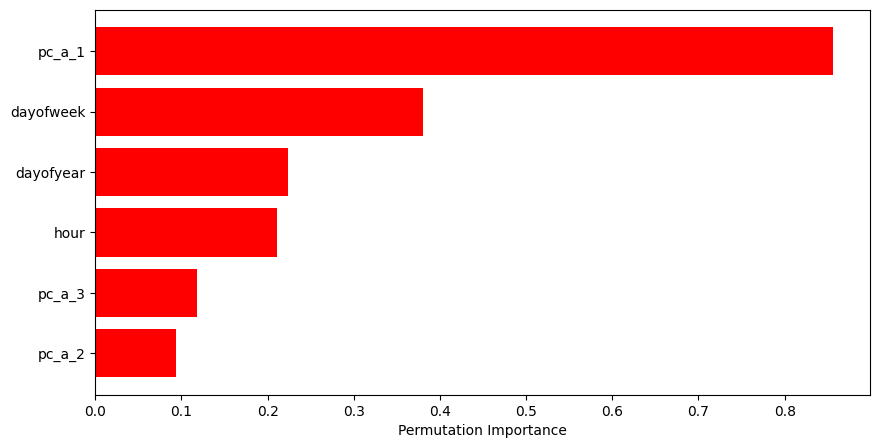

In [ ]:
model = make_pipeline(MinMaxScaler(),TransformedTargetRegressor(SVR(kernel='rbf'), transformer=StandardScaler()))

X = train_df_with_pca_and_time_features.iloc[:1000]
y = train_df['price_actual'].iloc[:1000]
model.fit(X, y)
result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=2)
plt.figure(figsize=(10, 5))
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X.shape[1]), result.importances_mean[sorted_idx], color="r", align="center")
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

FFT Variables


In [ ]:
from scipy.fft import fft, fftfreq

WINDOW_SIZE = 24 * 14

def calculate_fft_amplitude(data: np.ndarray, window_size=WINDOW_SIZE) -> tuple[np.ndarray, np.ndarray]:
    """
    FFT (高速フーリエ変換) を利用して、時系列データの周波数と振幅を算出します。

    Args:
        data (np.ndarray): FFTを適用する数値データの配列 (1次元)。
                           サンプル数は140と想定。
        window_size (int): ウィンドウサイズ。

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - frequencies (np.ndarray): 算出した周波数の配列。
            - amplitudes (np.ndarray): 算出した振幅の配列。
    """
    n = len(data) # サンプル数
    if n != window_size:
        print(f"Warning: Input data length is {n}, but {window_size} is expected.")

    # FFTを実行
    yf = fft(data)

    # サンプリング周波数 (ここでは時間の粒度を1日とするので、サンプリング周波数は1/日)
    # 時系列データが日ごとのデータ (resample('D')) なので、1日あたりのサンプリング間隔は1
    # サンプリング周波数は 1 / サンプリング間隔 = 1 / 1 = 1 (日^-1)
    # もし元のデータが1時間ごとなら、サンプリング間隔は1/24日なので、サンプリング周波数は24 (日^-1) になります。
    # ここでは日ごとのデータなので、サンプリング周波数は1とします。
    # f_s = 1.0 # 1日あたりのサンプリング周波数

    # サンプリング間隔 (ここでは1日)
    T = 1.0

    # 周波数を算出
    # fftfreqの第2引数はサンプリング間隔 (1/サンプリング周波数) です。
    frequencies = fftfreq(n, T)

    # 振幅を算出 (ナイキスト周波数までの片側スペクトル)
    # 複素数の振幅の絶対値を取り、正規化（サンプル数nで割る）し、
    # 交流成分は実部と虚部の2箇所に出るため2倍します。
    # 直流成分 (周波数0) は2倍しません。
    amplitudes = 2.0/n * np.abs(yf[0:n//2])
    frequencies = frequencies[0:n//2] # 周波数もナイキスト周波数まで

    return frequencies, amplitudes

def get_extracted_data(daily_df, window_size=WINDOW_SIZE):
  """
  指定されたwindow_sizeで1ステップづつシフトしたwindowを作成します。
  作成するwindowは未来データへのリークにならないよう日時tを基準として
  t以前の説明変数をパッケージングします。

  Args:
      daily_df (pd.DataFrame) : sourceデータ
      window_size (int): ウィンドウサイズ。

  Returns:
      [ (t : datetime, window : pd.DataFrame) ]:

          - t : windowの日時。
          - window : windowデータ。
  """

  extracted_data = []

  # price_actual_dailyは日ごとのデータなので、インデックスは日付です。
  # 抽出を開始する最初のインデックスから最後のインデックスまでループします。
  # 最後のインデックスは、ウィンドウサイズを考慮して決定します。
  for start_index in range(len(daily_df)):
    # 開始インデックスからウィンドウサイズ分のデータをスライス
    # ilocを使用して位置ベースで抽出します。
    extracted_window = daily_df.iloc[start_index : start_index + window_size]
    if len(extracted_window) < window_size:
      break
    # 抽出したウィンドウを配列に格納
    # DataFrameのまま格納することも、値をNumPy配列として格納することも可能です。
    # ここではDataFrameとして格納します。
    # 抽出したウィンドウを配列に格納
    # DataFrameのまま格納することも、値をNumPy配列として格納することも可能です。
    # ここではDataFrameとして格納します。
    extracted_data.append((extracted_window.index[-1], extracted_window))
  return extracted_data

def zero_crossing_median(values):
  """
  Calculate zero-crossings around the median of a list of numbers.

  Args:
      values (list or np.ndarray): A list or array of numerical data.

  Returns:
      int: The number of times the data crosses the median value.
  """
  if len(values) < 2:
    return 0

  # Calculate the median of the data
  median_value = np.median(values)

  # Shift the data by subtracting the median
  shifted_values = values - median_value

  # Find where the shifted values change sign
  # The sign change indicates a crossing of the original median
  sign_changes = np.diff(np.sign(shifted_values))

  # Count the number of non-zero entries in sign_changes.
  # A non-zero entry means a sign change occurred (crossing the median).
  zero_crossings = np.sum(sign_changes != 0)

  return zero_crossings


def get_fft_date(extracted_data, columns):
  """
  指定されたwindow_sizeで1ステップづつシフトしたwindowを作成します。

  Args:
      extracted_data ([pd.DataFrame]) : window_sizeで切り出されたwindowの配列。
      columns (list): fftを適用するカラムのリスト。

  Returns:
      fft_results (dict) : fft結果の辞書。キーはカラム。値はfft結果のDataFrame。

  """
  fft_results = {}
  for column in columns:
    amplitudes_data =[]
    index_data=[]
    stats_data = []
    for t, window_df in extracted_data:
      # price_actualの平均値の列 (price_actual_mean_daily) を使用
      data_to_fft = window_df[column].values
      data_min = window_df[column].min()
      data_max = window_df[column].max()
      data_mean = window_df[column].mean()
      data_std = window_df[column].std()
      data_zc = zero_crossing_median(window_df[column].values)

      # 欠損値が含まれている場合はスキップまたは補間などの処理が必要です。
      # ここでは欠損値がないと仮定します。
      if not np.isnan(data_to_fft).any():
        frequencies, amplitudes = calculate_fft_amplitude(data_to_fft)
        amplitudes_data.append(amplitudes)
        index_data.append(t)
        stats_data.append([data_min, data_max, data_mean, data_std, data_zc])
        #fft_results.append({'frequencies': frequencies, 'amplitudes': amplitudes, 'start_date': window_df.index[0], 'end_date' : window_df.index[-1]})
      else:
        print(f"Skipping window starting {window_df.index[0]} due to missing values.")
    amp_df = pd.DataFrame(amplitudes_data, index=index_data)
    stats_df = pd.DataFrame(stats_data, index=index_data, columns=['min', 'max', 'mean', 'std', 'zc'])
    fft_results[column] = amp_df.join(stats_df)
  return fft_results

def fft_correlation_by_column(fft_results, columns):
  """
  周波数成分とprice_actualとの相関をカラムごとに出力します。

  Args:
      fft_results(dict) : fft結果の辞書。キーはカラム。値はfft結果のDataFrame。
      columns (list): fftを適用するカラムのリスト。

  Returns:
      fft_corr_dict(dict) : 周波数成分とprice_actualとの相関を格納した辞書。

  """
  fft_corr_dict = {}
  for column in columns:
    fft_result = fft_results[column]
    fft_result = fft_result.join(train_df['price_actual'])
    fft_result_corr = pd.DataFrame({'price_actual':fft_result.corr(method='spearman')['price_actual']})
    fft_result_corr['abs_price_actual'] = fft_result_corr['price_actual'].abs()
    fft_result_corr = fft_result_corr[~fft_result_corr.index.isin(['price_actual'])]
    fft_corr_dict[column] = fft_result_corr
  return fft_corr_dict


def create_fft_correlation(daily_df, columns,is_train=True):
  """
  周波数成分とprice_actualとの相関辞書を作成します。
  キー : カラム
  値 : 周波数成分とprice_actualとの相関のDataFrame

  Args:
      daily_df : pd.DataFrame
      columns (list): fftを適用するカラムのリスト。
      is_train (bool): 学習データかどうか。

  Returns:
      fft_corr_dict(dict) : 周波数成分とprice_actualとの相関を格納した辞書。
      fft_results(dict) : fft結果の辞書。キーはカラム。値はfft結果のDataFrame。

  """
  extracted_data = get_extracted_data(daily_df)
  fft_results = get_fft_date(extracted_data, columns)
  if is_train:
    fft_corr_dict = fft_correlation_by_column(fft_results, columns)
  else:
    fft_corr_dict = None
  return fft_corr_dict, fft_results

def select_column(fft_corr_dict, z_score_threshold = 1.5):
  """
  price_actualとの相関の高いカラムを抽出します。

  Args:
      fft_corr_dict(dict) : 周波数成分とprice_actualとの相関を格納した辞書。
      z_score_threshold(float) : 抽出対象のz_scoreの閾値。

  Returns:
      values(pd.DataFrame) : z_scoreの閾値を超える周波数成分,カラムなどの情報。
  """

  values=[]
  for key, value in fft_corr_dict.items():
    value = value.copy()
    value['column'] = key
    value['index'] = value.index
    values.append(value)

  values = pd.concat(values, ignore_index=True)
  mean_val = values['abs_price_actual'].mean()
  std_val = values['abs_price_actual'].std()
  values['z_score'] = (values['abs_price_actual'] - mean_val) / std_val
  return values[values['z_score']>z_score_threshold]

def extract_by_select_column(select_column_df, fft_data):
  """
  カラム情報をもとにfftデータを抽出する。

  Args:
      select_column_df(pd.DataFrame) : z_scoreの閾値を超える周波数成分,カラムなどの情報。
      fft_data(pd.DataFrame) : fft結果のDataFrame
  Returns:
      extracted(pd.DataFrame) : 抽出したDataFrame
  """
  extracted = {}
  for column, index in zip(select_column_df['column'], select_column_df['index']):
    key = f"{column}_{index}"
    extracted[key] = fft_data[column][index]
  return pd.DataFrame(extracted)

In [ ]:
all_df = pd.concat([train_df[FEATURES], test_df[FEATURES]], ignore_index=False).sort_index()
test_start_pos = len(train_df) - WINDOW_SIZE + 1
train_for_stats = all_df.iloc[:len(train_df)].copy()
test_for_stats = all_df.iloc[test_start_pos:].copy()

In [ ]:
train_for_stats.tail(), test_for_stats.head()

(                           generation_biomass  \
 time                                            
 2017-12-31 18:00:00+00:00               286.0   
 2017-12-31 19:00:00+00:00               282.0   
 2017-12-31 20:00:00+00:00               284.0   
 2017-12-31 21:00:00+00:00               280.0   
 2017-12-31 22:00:00+00:00               290.0   
 
                            generation_fossil_brown_coal/lignite  \
 time                                                              
 2017-12-31 18:00:00+00:00                                   0.0   
 2017-12-31 19:00:00+00:00                                   0.0   
 2017-12-31 20:00:00+00:00                                   0.0   
 2017-12-31 21:00:00+00:00                                   0.0   
 2017-12-31 22:00:00+00:00                                   0.0   
 
                            generation_fossil_gas  generation_fossil_hard_coal  \
 time                                                                            
 2017-

In [ ]:
# 学習に使う特徴量を選定

fft_corr, fft_data_train = create_fft_correlation(train_for_stats, FEATURES)
_, fft_data_test = create_fft_correlation(test_for_stats, FEATURES, is_train=False)
selected_df = select_column(fft_corr,2.0)[['column','index']]

In [ ]:
train_extracted_fft_df = extract_by_select_column(selected_df, fft_data_train)
test_extracted_fft_df = extract_by_select_column(selected_df, fft_data_test)
train_extracted_fft_df.tail(), test_extracted_fft_df.head()


(                           generation_biomass_zc  \
 2017-12-31 18:00:00+00:00                      9   
 2017-12-31 19:00:00+00:00                     11   
 2017-12-31 20:00:00+00:00                     13   
 2017-12-31 21:00:00+00:00                     13   
 2017-12-31 22:00:00+00:00                      9   
 
                            generation_fossil_brown_coal/lignite_0  \
 2017-12-31 18:00:00+00:00                              978.005952   
 2017-12-31 19:00:00+00:00                              976.160714   
 2017-12-31 20:00:00+00:00                              974.214286   
 2017-12-31 21:00:00+00:00                              972.386905   
 2017-12-31 22:00:00+00:00                              970.625000   
 
                            generation_fossil_brown_coal/lignite_42  \
 2017-12-31 18:00:00+00:00                                12.727345   
 2017-12-31 19:00:00+00:00                                14.458246   
 2017-12-31 20:00:00+00:00                   

In [ ]:
test_extracted_fft_df.shape, train_extracted_fft_df.shape


((8760, 767), (25945, 767))

In [ ]:
train_all = train_extracted_fft_df
test_all = test_extracted_fft_df
train_all.tail(), test_all.head()

(                           generation_biomass_zc  \
 2017-12-31 18:00:00+00:00                      9   
 2017-12-31 19:00:00+00:00                     11   
 2017-12-31 20:00:00+00:00                     13   
 2017-12-31 21:00:00+00:00                     13   
 2017-12-31 22:00:00+00:00                      9   
 
                            generation_fossil_brown_coal/lignite_0  \
 2017-12-31 18:00:00+00:00                              978.005952   
 2017-12-31 19:00:00+00:00                              976.160714   
 2017-12-31 20:00:00+00:00                              974.214286   
 2017-12-31 21:00:00+00:00                              972.386905   
 2017-12-31 22:00:00+00:00                              970.625000   
 
                            generation_fossil_brown_coal/lignite_42  \
 2017-12-31 18:00:00+00:00                                12.727345   
 2017-12-31 19:00:00+00:00                                14.458246   
 2017-12-31 20:00:00+00:00                   

In [ ]:
train_all.shape, test_all.shape


((25945, 767), (8760, 767))

In [ ]:
pca_timeseries = PCA(n_components=10)
pca_timeseries.fit(train_all)
pca_timeseries.explained_variance_/pca_timeseries.explained_variance_.sum()

array([0.57126409, 0.23499794, 0.08464877, 0.04900641, 0.022342  ,
       0.01305585, 0.01232788, 0.00700626, 0.00275038, 0.0026004 ])

In [ ]:
time_series_pca_columns = [f'pca_{i}' for i in range(10)]
train_extracted_pca = pca_timeseries.transform(train_all)
train_all = pd.DataFrame(train_extracted_pca, index=train_all.index, columns=time_series_pca_columns)
train_all = add_time_features(train_all)
test_extracted_pca = pca_timeseries.transform(test_all)
test_all = pd.DataFrame(test_extracted_pca, index=test_all.index, columns=time_series_pca_columns)
test_all = add_time_features(test_all)
train_all.head(), test_all.head()

(                                pca_0       pca_1       pca_2        pca_3  \
 2015-01-15 22:00:00+00:00 -824.326110  232.266691  473.666362  1606.575116   
 2015-01-15 23:00:00+00:00 -825.070104  234.999789  483.393387  1608.462224   
 2015-01-16 00:00:00+00:00 -825.291938  233.823524  490.121090  1609.898775   
 2015-01-16 01:00:00+00:00 -825.460874  232.364138  493.362436  1609.226824   
 2015-01-16 02:00:00+00:00 -825.661968  231.871336  495.933589  1610.443631   
 
                                  pca_4        pca_5      pca_6        pca_7  \
 2015-01-15 22:00:00+00:00 -3350.166112 -1167.567833 -80.630979 -1127.815736   
 2015-01-15 23:00:00+00:00 -3356.290227 -1163.878613 -81.834844 -1127.214908   
 2015-01-16 00:00:00+00:00 -3363.517539 -1158.813007 -83.712907 -1127.629514   
 2015-01-16 01:00:00+00:00 -3369.258044 -1154.927280 -85.065888 -1126.924602   
 2015-01-16 02:00:00+00:00 -3371.903583 -1152.955143 -85.573279 -1127.347865   
 
                                 pca_8    

In [ ]:
EXPLANATORY_VARIABLES = ['pca_0', 'pca_1', 'pca_2', 'pca_3','pca_4','pca_5','pca_6', ]
X = train_all[EXPLANATORY_VARIABLES].join(train_df_with_pca_and_time_features)
y = train_df[train_df.index.isin(X.index)]['price_actual']
len(X), len(y)

(25945, 25945)

In [ ]:
X

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pc_a_1,pc_a_2,pc_a_3,hour,dayofweek,dayofyear
2015-01-15 22:00:00+00:00,-824.326110,232.266691,473.666362,1606.575116,-3350.166112,-1167.567833,-80.630979,-362.414982,1683.154499,2182.093786,22,3,15
2015-01-15 23:00:00+00:00,-825.070104,234.999789,483.393387,1608.462224,-3356.290227,-1163.878613,-81.834844,-375.200334,-1403.550258,2228.219234,23,3,15
2015-01-16 00:00:00+00:00,-825.291938,233.823524,490.121090,1609.898775,-3363.517539,-1158.813007,-83.712907,-388.333094,-3796.812459,2157.895220,0,4,16
2015-01-16 01:00:00+00:00,-825.460874,232.364138,493.362436,1609.226824,-3369.258044,-1154.927280,-85.065888,-395.234820,-5280.575049,2066.613973,1,4,16
2015-01-16 02:00:00+00:00,-825.661968,231.871336,495.933589,1610.443631,-3371.903583,-1152.955143,-85.573279,-397.085952,-5672.698748,2075.184281,2,4,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 18:00:00+00:00,-1067.739664,2182.174867,-434.507917,-1994.313963,-1677.260565,1081.707630,1118.194265,-350.862072,-673.186250,3926.820003,18,6,365
2017-12-31 19:00:00+00:00,-1063.526738,2152.615767,-464.836761,-1998.641389,-1678.045168,1087.583880,1114.580454,-349.399855,-361.842775,3880.038035,19,6,365
2017-12-31 20:00:00+00:00,-1059.606999,2124.654039,-494.492705,-2005.761733,-1679.720978,1093.134441,1111.037361,-350.545571,-461.685729,3864.774681,20,6,365
2017-12-31 21:00:00+00:00,-1055.593001,2097.010549,-525.792379,-2011.724727,-1678.410053,1097.026491,1108.326368,-355.280910,-1400.441068,3341.013679,21,6,365


In [4]:
X = pd.read_csv(os.path.join(DIR, 'X.csv'), index_col='Unnamed: 0', parse_dates=True)
y = pd.read_csv(os.path.join(DIR, 'y.csv'),index_col='time', parse_dates=True)
test = pd.read_csv(os.path.join(DIR, 'test.csv'), index_col='Unnamed: 0', parse_dates=True)

In [5]:
IMPORTANT_COLUMNS = ['pca_1', 'pca_2', 'pca_3','pca_4','pca_5', 'hour', 'dayofweek', 'dayofyear', 'pc_a_1', 'pc_a_2', 'pc_a_3']


#### SVR

In [19]:
# prompt: X, yをSVRでクロスバリデーション,評価はR2,RMSE,MAE
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import NuSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
# Define the number of folds for cross-validation
n_splits = 4
kf = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation results
r2_scores = []
rmse_scores = []
mae_scores = []

models = []

# Create the SVR model
model = make_pipeline(MinMaxScaler(),TransformedTargetRegressor(SVR(kernel='rbf'), transformer=StandardScaler()))

IMPORTANT_COLUMNS = ['pca_1', 'pca_2', 'pca_3','pca_4','pca_5', 'hour', 'dayofweek', 'dayofyear', 'pc_a_1', 'pc_a_2', 'pc_a_3']

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
  print(f"Fold {fold+1}/{n_splits}")

  X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  # Train the model
  model.fit(X_train, y_train)
  models.append(deepcopy(model))
  # Make predictions on the validation set
  y_pred = model.predict(X_val)

  # Evaluate the model
  r2 = r2_score(y_val, y_pred)
  rmse = root_mean_squared_error(y_val, y_pred) # squared=False for RMSE
  mae = mean_absolute_error(y_val, y_pred)

  print(f"  R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, start : {y_val.index.date[0]}, end : {y_val.index.date[-1]}")

  r2_scores.append(r2)
  rmse_scores.append(rmse)
  mae_scores.append(mae)

# Print the average evaluation scores across all folds
print("\n--- Average Scores ---")
print(f"Average R2: {np.mean(r2_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")

Fold 1/4
  R2: 0.2644, RMSE: 13.0296, MAE: 9.8627, start : 2015-08-20, end : 2016-03-23
Fold 2/4
  R2: -0.3293, RMSE: 12.6953, MAE: 10.8281, start : 2016-03-23, end : 2016-10-25
Fold 3/4
  R2: -0.1377, RMSE: 14.6688, MAE: 11.1830, start : 2016-10-25, end : 2017-05-29
Fold 4/4
  R2: -0.0732, RMSE: 10.4619, MAE: 8.3638, start : 2017-05-29, end : 2017-12-31

--- Average Scores ---
Average R2: -0.0689
Average RMSE: 12.7139
Average MAE: 10.0594


In [34]:
# # 評価結果を格納するリスト
# r2_scores_svr = []
# rmse_scores_svr = []
# mae_scores_svr = []

# models_svr = [] # 各フォールドで訓練されたモデルを保存

# # Create the SVR model pipeline
# # SVRは特徴量のスケールに敏感なため、MinMaxScalerをパイプラインに含めます。
# # また、ターゲット変数も標準化します。
# svr_pipeline = make_pipeline(
#     MinMaxScaler(),
#     TransformedTargetRegressor(
#         regressor=SVR(kernel='rbf'),
#         transformer=StandardScaler()
#     )
# )

# # Perform cross-validation
# for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
#     print(f"Fold {fold+1}/{n_splits}")

#     # 訓練データと検証データの分割
#     # SVRはカテゴリ変数を直接扱えないため、One-Hotエンコード済みのデータか、
#     # PCAなどで数値に変換された特徴量を使うのが一般的です。
#     # ここでは、渡されたIMPORTANT_COLUMNSをそのまま使います。
#     X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # モデルの訓練
#     svr_pipeline.fit(X_train, y_train)
#     models_svr.append(deepcopy(svr_pipeline)) # 訓練済みモデルを保存

#     # 検証セットで予測
#     y_pred_svr = svr_pipeline.predict(X_val)

#     # モデルの評価
#     r2 = r2_score(y_val, y_pred_svr)
#     rmse = root_mean_squared_error(y_val, y_pred_svr)
#     mae = mean_absolute_error(y_val, y_pred_svr)

#     print(f"  R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, start : {y_val.index.date[0]}, end : {y_val.index.date[-1]}")

#     r2_scores_svr.append(r2)
#     rmse_scores_svr.append(rmse)
#     mae_scores_svr.append(mae)

# # 全フォールドの平均評価スコアを出力
# print("\n--- SVR Average Scores ---")
# print(f"Average R2: {np.mean(r2_scores_svr):.4f}")
# print(f"Average RMSE: {np.mean(rmse_scores_svr):.4f}")
# print(f"Average MAE: {np.mean(mae_scores_svr):.4f}")


# # --- 2. 全学習データでの最終モデル学習 ---
# print("\n--- Final SVR Model Training on ALL training data ---")

# # 最終モデルを初期化 (CVでチューニングしたパラメータがあればここで設定)
# final_model_svr = make_pipeline(
#     MinMaxScaler(),
#     TransformedTargetRegressor(
#         regressor=SVR(kernel='rbf'),
#         transformer=StandardScaler()
#     )
# )

# # train_dfの全データを使って学習
# # XとyはCV前に準備した全学習データ
# final_model_svr.fit(X[IMPORTANT_COLUMNS], y)

# print("Final SVR model trained successfully.")


# # --- 3. 最終的なテストデータに対する予測の作成 ---
# # 全データで学習させた単一の最強モデルで予測
# final_predictions_svr = final_model_svr.predict(test[IMPORTANT_COLUMNS])

# print("\n--- Final SVR predictions for submission (first 5) ---")
# print(final_predictions_svr[:5])


# try:
#     if 'DIR' not in locals():
#         DIR = '.' # カレントディレクトリをデフォルトとする
#     sample_submit_svr_all = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
# except FileNotFoundError:
#     print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
#     exit() # ファイルがない場合は処理を終了

# sample_submit_svr_all['y_pred'] = final_predictions_svr
# print(sample_submit_svr_all)

Fold 1/4
  R2: 0.2644, RMSE: 13.0296, MAE: 9.8627, start : 2015-08-20, end : 2016-03-23
Fold 2/4
  R2: -0.3293, RMSE: 12.6953, MAE: 10.8281, start : 2016-03-23, end : 2016-10-25
Fold 3/4
  R2: -0.1377, RMSE: 14.6688, MAE: 11.1830, start : 2016-10-25, end : 2017-05-29
Fold 4/4
  R2: -0.0732, RMSE: 10.4619, MAE: 8.3638, start : 2017-05-29, end : 2017-12-31

--- SVR Average Scores ---
Average R2: -0.0689
Average RMSE: 12.7139
Average MAE: 10.0594

--- Final SVR Model Training on ALL training data ---
Final SVR model trained successfully.

--- Final SVR predictions for submission (first 5) ---
[[51.88865168]
 [49.41229219]
 [49.3877316 ]
 [50.00390006]
 [51.4534674 ]]
                           time     y_pred
0     2018-01-01 00:00:00+01:00  51.888652
1     2018-01-01 01:00:00+01:00  49.412292
2     2018-01-01 02:00:00+01:00  49.387732
3     2018-01-01 03:00:00+01:00  50.003900
4     2018-01-01 04:00:00+01:00  51.453467
...                         ...        ...
8755  2018-12-31 19:00:00+

In [10]:
sample_submit_svr = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'),header=None, names=['time','y_pred'])
y_pred = models[1].predict(test)
sample_submit_svr['y_pred'] = y_pred
sample_submit_svr

,time,y_pred
0,2018-01-01 00:00:00+01:00,56.197298
1,2018-01-01 01:00:00+01:00,39.964684
2,2018-01-01 02:00:00+01:00,39.768008
3,2018-01-01 03:00:00+01:00,40.419309
4,2018-01-01 04:00:00+01:00,41.694771
...,...,...
8755,2018-12-31 19:00:00+01:00,66.227197
8756,2018-12-31 20:00:00+01:00,65.957153
8757,2018-12-31 21:00:00+01:00,65.537631
8758,2018-12-31 22:00:00+01:00,64.998221


4foldのアンサンブル

In [23]:
# sample_submit_svr = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'),header=None, names=['time','y_pred'])
# predicted_svr = []
# for i in range(len(models)):
#   y_pred = models[i].predict(test[IMPORTANT_COLUMNS])
#   predicted_svr.append(y_pred)

# predicted_svr = np.mean(predicted_svr, axis=0)
# sample_submit_svr['y_pred'] = predicted_svr
# sample_submit_svr

,time,y_pred
0,2018-01-01 00:00:00+01:00,59.113545
1,2018-01-01 01:00:00+01:00,33.022460
2,2018-01-01 02:00:00+01:00,32.756189
3,2018-01-01 03:00:00+01:00,33.271350
4,2018-01-01 04:00:00+01:00,34.511221
...,...,...
8755,2018-12-31 19:00:00+01:00,70.179195
8756,2018-12-31 20:00:00+01:00,69.759722
8757,2018-12-31 21:00:00+01:00,69.359314
8758,2018-12-31 22:00:00+01:00,68.310977


#### Lightgbm

In [24]:
import pandas as pd
import numpy as np
import lightgbm as lgb # LightGBMをインポート
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler # ターゲット変数変換用
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor # ターゲット変数変換用
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore') # 警告を無視

# --- ここから、X, y, test, IMPORTANT_COLUMNS が既に準備されていることを想定 ---
# 例:
# X = pd.DataFrame(...) # 訓練用の特徴量データフレーム (DatetimeIndexを持つ)
# y = pd.Series(...)   # 訓練用のターゲット変数シリーズ (Xと同じDatetimeIndexを持つ)
# test = pd.DataFrame(...) # 予測用の特徴量データフレーム (DatetimeIndexを持つ)
# IMPORTANT_COLUMNS = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'hour', 'dayofweek', 'dayofyear', 'pc_a_1', 'pc_a_2', 'pc_a_3']
# --- 上記の変数は、このコードの実行前に定義されている必要があります ---

# Xとyの形状を確認（確認用）
if 'X' in locals() and 'y' in locals():
    print(f"X shape: {X.shape}, y shape: {y.shape}")
else:
    print("Error: X or y not found. Please ensure they are prepared before running this script.")
    # この後の処理は実行できないため、ここで終了するか、適切なエラーハンドリングを行う
    exit() # あるいは return

# Define the number of folds for cross-validation
n_splits = 4
kf = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation results
r2_scores_lgbm = []
rmse_scores_lgbm = []
mae_scores_lgbm = []

models_lgbm = [] # 各フォールドで訓練されたモデルを保存

print("\n--- Starting LightGBM Cross-Validation ---")

# Create the LightGBM model pipeline
# ツリーベースモデルなので特徴量のMinMaxScalerは不要。
# ターゲット変数の変換は、必要に応じて保持します。
lgbm_pipeline = make_pipeline(
    TransformedTargetRegressor(
        regressor=lgb.LGBMRegressor(objective='regression', # 回帰問題のデフォルト目的関数 (L2損失)
                                    metric='rmse',         # 評価指標をRMSEに設定
                                    n_estimators=1000,     # 推定器の数
                                    learning_rate=0.05,    # 学習率
                                    num_leaves=31,         # ツリーの葉の最大数
                                    max_depth=-1,          # ツリーの深さ (制限なし)
                                    min_child_samples=20,  # 葉に必要な最小データ数
                                    subsample=0.8,         # bagging fraction (各ツリーのデータサンプリング率)
                                    colsample_bytree=0.8,  # feature fraction (各ツリーの列サンプリング率)
                                    random_state=42,       # 再現性のためのシード
                                    n_jobs=-1,             # 全てのコアを使用
                                    # Categorical features を明示的に指定する場合
                                    # 'hour', 'dayofweek', 'dayofyear' がカテゴリカル列として適切であれば指定
                                    # categorical_feature=['hour', 'dayofweek', 'dayofyear']
                                   ),
        transformer=StandardScaler() # ターゲット変数の標準化
    )
)


# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
  print(f"Fold {fold+1}/{n_splits}")

  # 訓練データと検証データの分割
  X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  # モデルの訓練
  # LightGBMは通常、カテゴリカル特徴量を数値として渡しても機能しますが、
  # より最適に扱うために、LGBMRegressorのコンストラクタで categorical_feature 引数を
  # 指定することを検討してください。ただし、TransformedTargetRegressorとの組み合わせでは、
  # パイプライン内でデータ型を適切に管理するか、LGBMRegressorの引数に直接指定する必要があります。
  lgbm_pipeline.fit(X_train, y_train)
  models_lgbm.append(deepcopy(lgbm_pipeline)) # 訓練済みモデルを保存

  # 検証セットで予測
  y_pred_lgbm = lgbm_pipeline.predict(X_val)

  # モデルの評価
  r2_lgbm = r2_score(y_val, y_pred_lgbm)
  rmse_lgbm = root_mean_squared_error(y_val, y_pred_lgbm)
  mae_lgbm = mean_absolute_error(y_val, y_pred_lgbm)

  # 検証期間の日付範囲を表示
  print(f"  R2: {r2_lgbm:.4f}, RMSE: {rmse_lgbm:.4f}, MAE: {mae_lgbm:.4f}, start : {y_val.index.date[0]}, end : {y_val.index.date[-1]}")

  r2_scores_lgbm.append(r2_lgbm)
  rmse_scores_lgbm.append(rmse_lgbm)
  mae_scores_lgbm.append(mae_lgbm)

# 全フォールドの平均評価スコアを出力
print("\n--- LightGBM Average Scores ---")
print(f"Average R2: {np.mean(r2_scores_lgbm):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores_lgbm):.4f}")
print(f"Average MAE: {np.mean(mae_scores_lgbm):.4f}")


X shape: (25945, 13), y shape: (25945, 1)

--- Starting LightGBM Cross-Validation ---
Fold 1/4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 5189, number of used features: 11
[LightGBM] [Info] Start training from score 0.000000
  R2: 0.0706, RMSE: 14.6450, MAE: 10.6834, start : 2015-08-20, end : 2016-03-23
Fold 2/4
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

全てのtrainデータで学習

In [42]:
# # --- 1. 時系列クロスバリデーションで性能評価と最適学習回数の特定 ---
# print("\n--- Starting TimeSeries Cross-Validation ---")
# n_splits = 4
# kf = TimeSeriesSplit(n_splits=n_splits)

# oof_rmse_scores = []
# models_lgbm = []
# best_iterations = []

# # Perform cross-validation
# for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
#     print(f"Fold {fold+1}/{n_splits}")

#     # 訓練データと検証データの分割
#     X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # モデルの初期化
#     model_lgbm = lgb.LGBMRegressor(
#         objective='regression',
#         metric='rmse',
#         n_estimators=1000,
#         learning_rate=0.05,
#         random_state=42 + fold,
#         n_jobs=-1,
#         colsample_bytree=0.8,
#         subsample=0.8,
#         # 他のチューニング済みパラメータもここに設定
#     )

#     # モデルの訓練
#     model_lgbm.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
#     )

#     # 評価スコアと最適な学習回数を記録
#     y_pred_lgbm = model_lgbm.predict(X_val)
#     score = root_mean_squared_error(y_val, y_pred_lgbm)
#     oof_rmse_scores.append(score)
#     if model_lgbm.best_iteration_:
#         best_iterations.append(model_lgbm.best_iteration_)

#     print(f"  RMSE: {score:.4f}, Best Iteration: {model_lgbm.best_iteration_}")

# # --- CV結果の集計 ---
# print("\n--- Cross-Validation Average Scores ---")
# print(f"Average RMSE: {np.mean(oof_rmse_scores):.4f}")
# # CVで見つかった最適な学習回数の平均を計算
# # best_iterationsが空でなければ平均を計算、空ならデフォルト値を設定
# avg_best_iteration = int(np.mean(best_iterations)) if best_iterations else 500
# print(f"Average Best Iteration: {avg_best_iteration}")


# # --- 2. 全学習データでの最終モデル学習 ---
# print("\n--- Final Model Training on ALL training data ---")

# # 最適なパラメータで最終モデルを初期化
# final_model = lgb.LGBMRegressor(
#     objective='regression',
#     metric='rmse',
#     # ★★★ CVで見つけた最適な学習回数をn_estimatorsに設定 ★★★
#     n_estimators=90,
#     learning_rate=0.05,
#     random_state=42,
#     n_jobs=-1,
#     colsample_bytree=0.8,
#     subsample=0.8
# )

# # train_dfの全データを使って学習（早期停止は不要）
# # XとyはCV前に準備した全学習データ
# final_model.fit(X[IMPORTANT_COLUMNS], y)

# print("Final model trained successfully.")


# # --- 3. 最終的なテストデータに対する予測の作成 ---
# # 全データで学習させた単一の最強モデルで予測
# final_predictions_lgbm = final_model.predict(test[IMPORTANT_COLUMNS])

# print("\n--- Final predictions for submission (first 5) ---")
# print(final_predictions_lgbm[:5])


# try:
#     if 'DIR' not in locals():
#         DIR = '.' # カレントディレクトリをデフォルトとする
#     sample_submit_lgbm_all = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
# except FileNotFoundError:
#     print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
#     exit() # ファイルがない場合は処理を終了

# sample_submit_lgbm_all['y_pred'] = final_predictions_lgbm
# print(sample_submit_lgbm_all)


--- Starting TimeSeries Cross-Validation ---
Fold 1/4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 5189, number of used features: 11
[LightGBM] [Info] Start training from score 61.198449
  RMSE: 14.6778, Best Iteration: 63
Fold 2/4
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 10378, number of used features: 11
[LightGBM] [Info] Start training from 

4foldのアンサンブル

In [7]:
if 'test' in locals() and 'IMPORTANT_COLUMNS' in locals() and 'models_lgbm' in locals() and len(models_lgbm) > 0:
    # `sample_submit.csv` を読み込む
    # DIRがまだ定義されていなければ、ここで定義してください
    try:
        if 'DIR' not in locals():
            DIR = '.' # カレントディレクトリをデフォルトとする
        sample_submit_lgbm = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
    except FileNotFoundError:
        print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
        exit() # ファイルがない場合は処理を終了

    # test データから予測に必要な列を選択
    # `test` データフレームが、`train_all[EXPLANATORY_VARIABLES].join(train_df_with_pca_and_time_features)`
    # と同様の構造（PCA後の時系列特徴量と、列方向PCA・時間特徴量が結合されたもの）である必要があります。
    test_processed = test[IMPORTANT_COLUMNS]

    # 訓練済みモデルで予測 (ここでは最初のフォールドのモデルを使用)
    y_pred_final = models_lgbm[1].predict(test_processed)

    # sample_submit DataFrameに予測値を格納
    sample_submit_lgbm['y_pred'] = y_pred_final

In [25]:
# if 'test' in locals() and 'IMPORTANT_COLUMNS' in locals() and 'models_lgbm' in locals() and len(models_lgbm) > 0:
#     # `sample_submit.csv` を読み込む
#     # DIRがまだ定義されていなければ、ここで定義してください
#     try:
#         if 'DIR' not in locals():
#             DIR = '.' # カレントディレクトリをデフォルトとする
#         sample_submit_lgbm = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
#     except FileNotFoundError:
#         print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
#         exit() # ファイルがない場合は処理を終了

#     # test データから予測に必要な列を選択
#     # `test` データフレームが、`train_all[EXPLANATORY_VARIABLES].join(train_df_with_pca_and_time_features)`
#     # と同様の構造（PCA後の時系列特徴量と、列方向PCA・時間特徴量が結合されたもの）である必要があります。
#     test_processed = test[IMPORTANT_COLUMNS]

#     y_pred_final = []

#     for i in range(len(models_lgbm)):

#       # 訓練済みモデルで予測 (ここでは最初のフォールドのモデルを使用)
#       fold_predict = models_lgbm[i].predict(test_processed)
#       y_pred_final.append(fold_predict)

#     y_pred_final = np.mean(y_pred_final, axis=0)

#     # sample_submit DataFrameに予測値を格納
#     sample_submit_lgbm['y_pred'] = y_pred_final

In [8]:
sample_submit_lgbm

,time,y_pred
0,2018-01-01 00:00:00+01:00,60.610725
1,2018-01-01 01:00:00+01:00,44.042085
2,2018-01-01 02:00:00+01:00,39.586185
3,2018-01-01 03:00:00+01:00,38.986869
4,2018-01-01 04:00:00+01:00,39.509301
...,...,...
8755,2018-12-31 19:00:00+01:00,72.241417
8756,2018-12-31 20:00:00+01:00,75.707293
8757,2018-12-31 21:00:00+01:00,75.476975
8758,2018-12-31 22:00:00+01:00,68.851182


### XGBoost


In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb # XGBoostをインポート
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

# --- ここから、X, y, test, IMPORTANT_COLUMNS が既に準備されていることを想定 ---
# (このコードの実行前に、以前のノートブックのセルで変数が定義されている必要があります)

# --- XGBoostのためのデータ準備 (カテゴリ変数の型変換) ---
# XGBoostにカテゴリ変数を正しく認識させるため、事前にデータ型を 'category' に変更します。
categorical_to_convert = [col for col in ['hour', 'dayofweek', 'dayofyear'] if col in IMPORTANT_COLUMNS]

if categorical_to_convert:
    print(f"XGBoostのために、次のカラムのデータ型を 'category' に変換します: {categorical_to_convert}")
    # .copy() を使って SettingWithCopyWarning を回避
    X = X.copy()
    test = test.copy()
    for col in categorical_to_convert:
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')

# Xとyの形状を確認（確認用）
if 'X' in locals() and 'y' in locals():
    print(f"X shape: {X.shape}, y shape: {y.shape}")
else:
    print("Error: X or y not found.")
    exit()

# Define the number of folds for cross-validation
n_splits = 4
kf = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation results
r2_scores_xgb = []
rmse_scores_xgb = []
mae_scores_xgb = []

models_xgb = [] # 各フォールドで訓練されたモデルを保存

print("\n--- Starting XGBoost Cross-Validation (using Native API) ---")

# --- ★★★ XGBoost ネイティブAPI用のパラメータを定義 ★★★ ---
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'enable_categorical': True
}

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
  print(f"Fold {fold+1}/{n_splits}")

  # 訓練データと検証データの分割
  X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  # --- ★★★ XGBoost ネイティブAPI用のデータ形式 (DMatrix) に変換 ★★★ ---
  dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
  dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

  # --- ★★★ xgb.train() を使ってモデルを学習 ★★★ ---
  model_xgb = xgb.train(
      params=params,
      dtrain=dtrain,
      num_boost_round=1000, # n_estimatorsに相当
      evals=[(dval, 'eval')],
      early_stopping_rounds=50,
      verbose_eval=False # 学習中のログを非表示に
  )
  models_xgb.append(deepcopy(model_xgb)) # 訓練済みモデルを保存

  # 検証セットで予測
  dval_pred = xgb.DMatrix(X_val, enable_categorical=True) # 予測用データもDMatrixに
  y_pred_xgb = model_xgb.predict(dval_pred)

  # モデルの評価
  r2_xgb = r2_score(y_val, y_pred_xgb)
  rmse_xgb = root_mean_squared_error(y_val, y_pred_xgb)
  mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

  # 検証期間の日付範囲を表示
  print(f"  R2: {r2_xgb:.4f}, RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, start : {y_val.index.date[0]}, end : {y_val.index.date[-1]}")

  r2_scores_xgb.append(r2_xgb)
  rmse_scores_xgb.append(rmse_xgb)
  mae_scores_xgb.append(mae_xgb)

# 全フォールドの平均評価スコアを出力
print("\n--- XGBoost Average Scores ---")
print(f"Average R2: {np.mean(r2_scores_xgb):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores_xgb):.4f}")
print(f"Average MAE: {np.mean(mae_scores_xgb):.4f}")


XGBoostのために、次のカラムのデータ型を 'category' に変換します: ['hour', 'dayofweek', 'dayofyear']
X shape: (25945, 13), y shape: (25945, 1)

--- Starting XGBoost Cross-Validation (using Native API) ---
Fold 1/4
  R2: -0.6142, RMSE: 19.3006, MAE: 16.7517, start : 2015-08-20, end : 2016-03-23
Fold 2/4
  R2: -1.0518, RMSE: 15.7722, MAE: 13.8264, start : 2016-03-23, end : 2016-10-25
Fold 3/4
  R2: -0.3155, RMSE: 15.7740, MAE: 12.8060, start : 2016-10-25, end : 2017-05-29
Fold 4/4
  R2: 0.1813, RMSE: 9.1379, MAE: 7.1590, start : 2017-05-29, end : 2017-12-31

--- XGBoost Average Scores ---
Average R2: -0.4501
Average RMSE: 14.9962
Average MAE: 12.6358


全てのtrainデータで学習

In [38]:
# # --- XGBoostのためのデータ準備 (カテゴリ変数の型変換) ---
# # XGBoostにカテゴリ変数を正しく認識させるため、事前にデータ型を 'category' に変更します。
# categorical_to_convert = [col for col in ['hour', 'dayofweek', 'dayofyear'] if col in IMPORTANT_COLUMNS]

# if categorical_to_convert:
#     print(f"XGBoostのために、次のカラムのデータ型を 'category' に変換します: {categorical_to_convert}")
#     # .copy() を使って SettingWithCopyWarning を回避
#     X = X.copy()
#     test = test.copy()
#     for col in categorical_to_convert:
#         X[col] = X[col].astype('category')
#         test[col] = test[col].astype('category')

# # Xとyの形状を確認（確認用）
# if 'X' in locals() and 'y' in locals():
#     print(f"X shape: {X.shape}, y shape: {y.shape}")
# else:
#     print("Error: X or y not found. Please ensure they are prepared before running this script.")
#     exit()

# # --- 1. XGBoostによる時系列クロスバリデーション (ネイティブAPI使用) ---
# print("\n--- Starting XGBoost TimeSeries Cross-Validation ---")
# n_splits = 4
# kf = TimeSeriesSplit(n_splits=n_splits)

# # 評価結果を格納するリスト
# r2_scores_xgb = []
# rmse_scores_xgb = []
# mae_scores_xgb = []
# best_iterations = []

# models_xgb = [] # 各フォールドで訓練されたモデルを保存

# # XGBoostのハイパーパラメータを辞書で定義
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'learning_rate': 0.05,
#     'max_depth': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'random_state': 42,
#     'n_jobs': -1,
#     'enable_categorical': True
# }

# # Perform cross-validation
# for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
#     print(f"Fold {fold+1}/{n_splits}")

#     # 訓練データと検証データの分割
#     X_train, X_val = X[IMPORTANT_COLUMNS].iloc[train_index], X[IMPORTANT_COLUMNS].iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # XGBoost専用のデータ形式 (DMatrix) に変換
#     dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
#     dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

#     # モデルの訓練 (xgb.train を使用)
#     model_xgb = xgb.train(
#         params=params,
#         dtrain=dtrain,
#         num_boost_round=1000, # n_estimatorsに相当
#         evals=[(dtrain, 'train'), (dval, 'eval')],
#         early_stopping_rounds=50,
#         verbose_eval=False # 学習中のログを非表示に
#     )
#     models_xgb.append(deepcopy(model_xgb))
#     best_iterations.append(model_xgb.best_iteration)

#     # 検証セットで予測
#     dval_pred = xgb.DMatrix(X_val, enable_categorical=True)
#     y_pred_xgb = model_xgb.predict(dval_pred)

#     # モデルの評価
#     r2 = r2_score(y_val, y_pred_xgb)
#     rmse = root_mean_squared_error(y_val, y_pred_xgb)
#     mae = mean_absolute_error(y_val, y_pred_xgb)

#     print(f"  R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, start : {y_val.index.date[0]}, end : {y_val.index.date[-1]}")

#     r2_scores_xgb.append(r2)
#     rmse_scores_xgb.append(rmse)
#     mae_scores_xgb.append(mae)

# # 全フォールドの平均評価スコアを出力
# print("\n--- XGBoost Average Scores ---")
# print(f"Average R2: {np.mean(r2_scores_xgb):.4f}")
# print(f"Average RMSE: {np.mean(rmse_scores_xgb):.4f}")
# print(f"Average MAE: {np.mean(mae_scores_xgb):.4f}")
# avg_best_iteration = int(np.mean(best_iterations)) if best_iterations else 500
# print(f"Average Best Iteration: {avg_best_iteration}")


# # --- 2. 全学習データでの最終モデル学習 ---
# print("\n--- Final XGBoost Model Training on ALL training data ---")

# # 全学習データをDMatrixに変換
# dtrain_all = xgb.DMatrix(X[IMPORTANT_COLUMNS], label=y, enable_categorical=True)

# # CVで見つけた最適な学習回数をnum_boost_roundに設定して最終学習
# final_model_xgb = xgb.train(
#     params=params,
#     dtrain=dtrain_all,
#     num_boost_round=avg_best_iteration, # CVで見つけた回数を指定
#     verbose_eval=False
# )

# print("Final XGBoost model trained successfully.")


# # --- 3. 最終的なテストデータに対する予測の作成 ---
# # 全データで学習させた単一の最強モデルで予測
# dtest = xgb.DMatrix(test[IMPORTANT_COLUMNS], enable_categorical=True)
# final_predictions_xgb = final_model_xgb.predict(dtest)

# print("\n--- Final XGBoost predictions for submission (first 5) ---")
# print(final_predictions_xgb[:5])

# try:
#     if 'DIR' not in locals():
#         DIR = '.' # カレントディレクトリをデフォルトとする
#     sample_submit_xgb_all = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
# except FileNotFoundError:
#     print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
#     exit() # ファイルがない場合は処理を終了

# sample_submit_xgb_all['y_pred'] = final_predictions_lgbm
# print(sample_submit_xgb_all)

XGBoostのために、次のカラムのデータ型を 'category' に変換します: ['hour', 'dayofweek', 'dayofyear']
X shape: (25945, 13), y shape: (25945, 1)

--- Starting XGBoost TimeSeries Cross-Validation ---
Fold 1/4
  R2: -0.6142, RMSE: 19.3006, MAE: 16.7517, start : 2015-08-20, end : 2016-03-23
Fold 2/4
  R2: -1.0518, RMSE: 15.7722, MAE: 13.8264, start : 2016-03-23, end : 2016-10-25
Fold 3/4
  R2: -0.3155, RMSE: 15.7740, MAE: 12.8060, start : 2016-10-25, end : 2017-05-29
Fold 4/4
  R2: 0.1813, RMSE: 9.1379, MAE: 7.1590, start : 2017-05-29, end : 2017-12-31

--- XGBoost Average Scores ---
Average R2: -0.4501
Average RMSE: 14.9962
Average MAE: 12.6358
Average Best Iteration: 114

--- Final XGBoost Model Training on ALL training data ---
Final XGBoost model trained successfully.

--- Final XGBoost predictions for submission (first 5) ---
[32.56806  52.799706 52.386883 51.89377  51.836937]
                           time     y_pred
0     2018-01-01 00:00:00+01:00  38.030435
1     2018-01-01 01:00:00+01:00  52.780706
2   

In [12]:
if 'test' in locals() and 'IMPORTANT_COLUMNS' in locals() and 'models_lgbm' in locals() and len(models_lgbm) > 0:
    # `sample_submit.csv` を読み込む
    # DIRがまだ定義されていなければ、ここで定義してください
    try:
        if 'DIR' not in locals():
            DIR = '.' # カレントディレクトリをデフォルトとする
        sample_submit_xgb = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
    except FileNotFoundError:
        print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
        exit() # ファイルがない場合は処理を終了

    # test データから予測に必要な列を選択
    # `test` データフレームが、`train_all[EXPLANATORY_VARIABLES].join(train_df_with_pca_and_time_features)`
    # と同様の構造（PCA後の時系列特徴量と、列方向PCA・時間特徴量が結合されたもの）である必要があります。
    test_processed = test[IMPORTANT_COLUMNS]

    # 予測用データをDMatrix形式に変換
    #    enable_categorical=Trueを忘れないようにします
    dtest = xgb.DMatrix(test_processed, enable_categorical=True)


    # 訓練済みモデルで予測 (ここでは最初のフォールドのモデルを使用)
    y_pred_final = models_xgb[1].predict(dtest)

    # sample_submit DataFrameに予測値を格納
    sample_submit_xgb['y_pred'] = y_pred_final


4foldのアンサンブル

In [27]:
# if 'test' in locals() and 'IMPORTANT_COLUMNS' in locals() and 'models_lgbm' in locals() and len(models_lgbm) > 0:
#     # `sample_submit.csv` を読み込む
#     # DIRがまだ定義されていなければ、ここで定義してください
#     try:
#         if 'DIR' not in locals():
#             DIR = '.' # カレントディレクトリをデフォルトとする
#         sample_submit_xgb = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'), header=None, names=['time', 'y_pred'])
#     except FileNotFoundError:
#         print(f"Error: sample_submit.csv not found at {os.path.join(DIR, 'sample_submit.csv')}. Please ensure the file exists.")
#         exit() # ファイルがない場合は処理を終了

#     # test データから予測に必要な列を選択
#     # `test` データフレームが、`train_all[EXPLANATORY_VARIABLES].join(train_df_with_pca_and_time_features)`
#     # と同様の構造（PCA後の時系列特徴量と、列方向PCA・時間特徴量が結合されたもの）である必要があります。
#     test_processed = test[IMPORTANT_COLUMNS]

#     # 予測用データをDMatrix形式に変換
#     #    enable_categorical=Trueを忘れないようにします
#     dtest = xgb.DMatrix(test_processed, enable_categorical=True)

#     y_pred_final_xgb = []

#     for i in range(len(models_xgb)):
#       fold_predict = models_xgb[i].predict(dtest)
#       y_pred_final_xgb.append(fold_predict)

#     y_pred_final = np.mean(y_pred_final_xgb, axis=0)

#     # sample_submit DataFrameに予測値を格納
#     sample_submit_xgb['y_pred'] = y_pred_final

In [18]:
sample_submit_xgb

,time,y_pred
0,2018-01-01 00:00:00+01:00,55.487717
1,2018-01-01 01:00:00+01:00,49.431751
2,2018-01-01 02:00:00+01:00,47.867516
3,2018-01-01 03:00:00+01:00,46.922195
4,2018-01-01 04:00:00+01:00,46.731682
...,...,...
8755,2018-12-31 19:00:00+01:00,69.314369
8756,2018-12-31 20:00:00+01:00,69.906502
8757,2018-12-31 21:00:00+01:00,66.885765
8758,2018-12-31 22:00:00+01:00,62.645775


In [13]:
xsample_submit_xgb

,time,y_pred
0,2018-01-01 00:00:00+01:00,64.036385
1,2018-01-01 01:00:00+01:00,55.931828
2,2018-01-01 02:00:00+01:00,55.250793
3,2018-01-01 03:00:00+01:00,55.405304
4,2018-01-01 04:00:00+01:00,55.405304
...,...,...
8755,2018-12-31 19:00:00+01:00,82.391418
8756,2018-12-31 20:00:00+01:00,84.601730
8757,2018-12-31 21:00:00+01:00,80.634613
8758,2018-12-31 22:00:00+01:00,75.760674


### アンサンブルの実行

In [21]:
# # LightGBMの予測結果を追加
# df_ensemble = pd.merge(
#     sample_submit_svr_all.rename(columns = {'y_pred': 'y_pred_svr'}),
#     sample_submit_lgbm_all.rename(columns={'y_pred': 'y_pred_lgbm'}),
#     on='time',
#     how='inner'  # timeが共通する行のみを結合
# )

# # XGBoostの予測結果を追加
# df_ensemble = pd.merge(
#     df_ensemble,
#     sample_submit_xgb_all.rename(columns={'y_pred': 'y_pred_xgb'}),
#     on='time',
#     how='inner'
# )
# df_ensemble

NameError: name 'sample_submit_svr_all' is not defined

In [28]:
# LightGBMの予測結果を追加
df_ensemble = pd.merge(
    sample_submit_svr.rename(columns = {'y_pred': 'y_pred_svr'}),
    sample_submit_lgbm.rename(columns={'y_pred': 'y_pred_lgbm'}),
    on='time',
    how='inner'  # timeが共通する行のみを結合
)

# XGBoostの予測結果を追加
df_ensemble = pd.merge(
    df_ensemble,
    sample_submit_xgb.rename(columns={'y_pred': 'y_pred_xgb'}),
    on='time',
    how='inner'
)
df_ensemble

,time,y_pred_svr,y_pred_lgbm,y_pred_xgb
0,2018-01-01 00:00:00+01:00,59.113545,49.030702,55.487717
1,2018-01-01 01:00:00+01:00,33.022460,43.377142,49.431751
2,2018-01-01 02:00:00+01:00,32.756189,40.773593,47.867516
3,2018-01-01 03:00:00+01:00,33.271350,39.048789,46.922195
4,2018-01-01 04:00:00+01:00,34.511221,38.988749,46.731682
...,...,...,...,...
8755,2018-12-31 19:00:00+01:00,70.179195,63.741542,69.314369
8756,2018-12-31 20:00:00+01:00,69.759722,65.294352,69.906502
8757,2018-12-31 21:00:00+01:00,69.359314,62.840187,66.885765
8758,2018-12-31 22:00:00+01:00,68.310977,55.037524,62.645775


In [29]:
# --- アンサンブル予測の計算 ---
pred_cols = ['y_pred_svr', 'y_pred_lgbm', 'y_pred_xgb']
df_ensemble['y_pred_ensemble'] = df_ensemble[pred_cols].mean(axis=1)

# 提出用フォーマットに整形
final_submission = df_ensemble.reset_index()[['time', 'y_pred_ensemble']]
final_submission.columns = ['time', 'y_pred'] # 列名を元のフォーマットに戻す

# print(f"\nEnsembled submission file created successfully at: {ensemble_filename}")
print("\nFirst 5 rows of the ensembled submission file:")
print(final_submission.head())
print("\nDescriptive statistics of the ensembled predictions:")
print(final_submission['y_pred'].describe())


First 5 rows of the ensembled submission file:
                        time     y_pred
0  2018-01-01 00:00:00+01:00  54.543988
1  2018-01-01 01:00:00+01:00  41.943784
2  2018-01-01 02:00:00+01:00  40.465766
3  2018-01-01 03:00:00+01:00  39.747445
4  2018-01-01 04:00:00+01:00  40.077217

Descriptive statistics of the ensembled predictions:
count    8760.000000
mean       53.713473
std         8.983224
min        24.911778
25%        47.602244
50%        54.233675
75%        60.741017
max        77.054437
Name: y_pred, dtype: float64


In [ ]:
# # # # アンサンブル結果をCSVに保存
# ensemble_filename = os.path.join(submission_path, 'submit_ensemble_svr_lgbm_xgb_vol.4.csv')
# final_submission.to_csv(ensemble_filename, index=False, header=None)